In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# List the contents of your Google Drive 'MyDrive' directory
print(os.listdir('/content/drive/MyDrive'))

['Getting started.pdf', 'IMG_20171206_114544.jpg', 'IMG-20171206-WA0000.jpg', 'ticket', 'Admit_123768.pdf', 'HSTU_Admit_Card_101542.pdf', 'B_Unit.pdf', 'precs', 'Apply form (job) (16 07 2017).pdf', 'Classroom', 'Rafsan Pic 1 (1).jpg', 'Rafsan Pic 1.jpg', 'Rafsan Scholarship000.pdf', 'Document', 'AMN SERVICE POINT.docx', '01 Python Basics.gdoc', '20201008_Abdul Munnaf Rafsan_06_ CSE110 Assignment02 (1).ipynb', 'abdul_munnaf_rafsan_20201008_section_6_set_QCY.ipynb', '20201008_Abdul_Munnaf_Rafsan_06__SET_CX2.ipynb', '20201165_Md_Rayhan_Sarker_06_CSE110 Assignment05 (Function).ipynb', '2018-02-21-17-24-37-202.jpg', '20201008_Abdul_Munnaf_Rafsan_06_CSE110_Assignment04_(Tuple_Dictionary).ipynb', '20201008_Abdul_Munnaf_Rafsan_06_CSE110_final_fall2020.ipynb', 'Assignment02_20301423_Hasibul_Hasan_Ahmed_01 (1).ipynb', '2.5 Annotation_ old-majors-speech.gdoc', 'CSE111 Lab Assignment 3 (2).gdoc', 'CSE111 Lab Assignment 3 (1).gdoc', 'CSE111 Lab Assignment 3.gdoc', 'CSE111 Lab Assignment 4 (4).gdoc'

In [ ]:
print(os.listdir('/content/drive/MyDrive/Image'))


['721c76d1985ed42afd2b25d0b5a7d0dd.jpg', 'Capture.PNG']


In [ ]:
pip install torch transformers diffusers datasets


In [ ]:
# Required libraries
import torch
import transformers
from diffusers import StableDiffusionImg2ImgPipeline
import datasets
import os
from PIL import Image
import numpy as np


In [ ]:
# Load the pre-trained Stable Diffusion model (image-to-image)
model_name = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_name, torch_dtype=torch.float16)
pipe.to("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise use CPU



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
import os
def prepare_dataset(path='/content/drive/MyDrive/Image'):
    # Assuming the images are in 'source_images' and 'target_images' subfolders
    source_folder = os.path.join(path, 'source_images')
    target_folder = os.path.join('/content/drive/MyDrive/Image', 'target_images')

    # Get the list of image files (assuming they are the same in both folders)
    source_images = sorted(os.listdir(source_folder))
    target_images = sorted(os.listdir(target_folder))

    # Ensure both source and target folders have the same number of images
    assert len(source_images) == len(target_images), "Mismatch between source and target images"

    # Prepare the image pairs
    image_pairs = []
    for src_img, tgt_img in zip(source_images, target_images):
        source_image_path = os.path.join(source_folder, src_img)
        target_image_path = os.path.join(target_folder, tgt_img)

        # Load images using PIL (or other library)
        source_img = Image.open(source_image_path).convert("RGB")
        target_img = Image.open(target_image_path).convert("RGB")

        # You can add any preprocessing steps here (resize, normalize, etc.)
        # For now, we will just convert to numpy arrays
        source_img = np.array(source_img)
        target_img = np.array(target_img)

        image_pairs.append((source_img, target_img))

    return image_pairs



In [ ]:
training_args = {
    'learning_rate': 1e-4,
    'num_train_epochs': 10,
    'per_device_train_batch_size': 4,
    'mixed_precision': 'fp16'  # Use mixed precision to save memory
}


In [ ]:
from transformers import Trainer, TrainingArguments

def fine_tune_model(model, dataset, training_args):
    # Define a custom dataset for PyTorch
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, image_pairs):
            self.image_pairs = image_pairs

        def __len__(self):
            return len(self.image_pairs)

        def __getitem__(self, idx):
            source_image, target_image = self.image_pairs[idx]
            # Convert the images to tensors (PyTorch format)
            return {
                "pixel_values": torch.tensor(source_image).permute(2, 0, 1).float(),  # Channel first
                "labels": torch.tensor(target_image).permute(2, 0, 1).float()  # Channel first
            }

    # Create the dataset from the image pairs
    train_dataset = CustomDataset(dataset)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=TrainingArguments(**training_args),
        train_dataset=train_dataset
    )

    # Start training
    trainer.train()


In [ ]:
def test_image_to_image(model, test_image, prompt="Desired transformation description"):
    # Generate the output image using the pipeline
    pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(model)
    output_image = pipeline(image=test_image, prompt=prompt).images[0]
    return output_image


In [ ]:
import os
from PIL import Image
import numpy as np

def prepare_dataset(image_folder_path="/content/drive/MyDrive/Image"):  # Set the default path
    # Load images directly from the folder (no subfolders)
    image_files = sorted(os.listdir(image_folder_path))

    # Ensure there are at least two images (source and target)
    if len(image_files) < 2:
        raise ValueError("There should be at least two images for source and target.")

    # Prepare the image pairs (assuming source and target are sequentially ordered)
    image_pairs = []
    for img_file in image_files:
        image_path = os.path.join(image_folder_path, img_file)

        # Load the image
        img = Image.open(image_path).convert("RGB")

        # Convert the image to a numpy array
        img_array = np.array(img)

        # Apply a transformation to the target image (e.g., rotate by 45 degrees)
        target_img_transformed = img.rotate(45)  # Rotation transformation for the target image

        # Convert the transformed target image to a numpy array
        target_img_transformed_array = np.array(target_img_transformed)

        # Append the source and transformed target image as a pair
        image_pairs.append((img_array, target_img_transformed_array))

    return image_pairs

# Now use the path you've provided
image_folder_path = "/content/drive/MyDrive/Image"
dataset = prepare_dataset(image_folder_path)

# Check the first image pair
source_img, target_img = dataset[0]


In [ ]:
from PIL import Image

# Convert numpy array back to PIL image
source_img_pil = Image.fromarray(source_img)
target_img_pil = Image.fromarray(target_img)

# Display the images
source_img_pil.show()  # Display the source image
target_img_pil.show()  # Display the target image



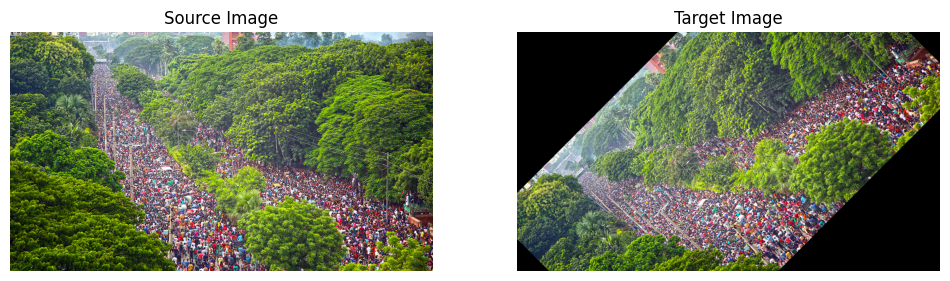

In [ ]:
import matplotlib.pyplot as plt

# Create a figure to display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the source image
axes[0].imshow(source_img)
axes[0].set_title("Source Image")
axes[0].axis('off')

# Display the target image
axes[1].imshow(target_img)
axes[1].set_title("Target Image")
axes[1].axis('off')

plt.show()
